# Введение в нейронные сети

## Урок 4. Сверточные нейронные сети

In [ ]:
#!pip install opencv-python

In [ ]:
#!pip install imblearn

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler

from tqdm import tqdm

import cv2

In [2]:
data = pd.read_csv('train.csv')
data.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [3]:
data.shape

(7095, 3)

### Разведочный анализ данных

In [4]:
data["ClassId"].value_counts()

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

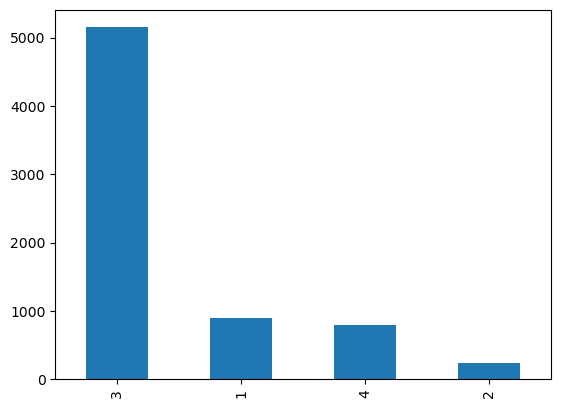

In [5]:
data["ClassId"].value_counts().plot(kind = 'bar');

In [6]:
l1=[]
l2=[]
for img, ClassId, EncodedPixels in tqdm(data.values):
    try:
        image = cv2.imread("img/{}".format(img), cv2.IMREAD_COLOR)
        image = cv2.resize(image,(120,120))
        l1.append(image)
        l2.append(ClassId)
    except:
        continue

100%|█████████████████████████████████████████████████████████████████████████████| 7095/7095 [00:11<00:00, 614.75it/s]


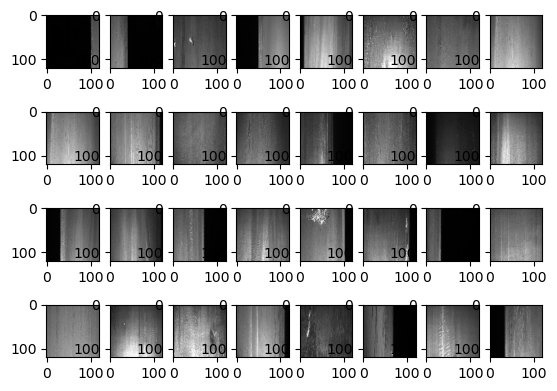

In [7]:
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(l1[i])
plt.show()

In [8]:
X = np.array(l1)
X = X / 255

encoder = LabelEncoder()
y = encoder.fit_transform(l2)
y = np.array(y)

In [9]:
X.shape, y.shape

((351, 120, 120, 3), (351,))

### Борьба с дибалансом

In [10]:
reshaped_X = X.reshape(X.shape[0], -1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X, y)
X = X.reshape(-1, 120, 120, 3)
X.shape

(984, 120, 120, 3)

In [11]:
y = to_categorical(y)
y.shape

(984, 4)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (787, 120, 120, 3)
x_test размер: (197, 120, 120, 3)
y_train размер: (787, 4)
y_test размер: (197, 4)


### Построение нейронной сети в 3 слоя

In [13]:
model=Sequential()
model.add(Conv2D(32, (3,3), input_shape=(120,120,3), activation="relu"))
model.add(Flatten())
model.add(Dense(4, activation="softmax"))

In [14]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [15]:
erly_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [16]:
history = model.fit(X_train,
                    y_train,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    batch_size=128,
                    verbose=1, 
                    callbacks=[erly_stoping])

Epoch 1/25
7/7 [==============================] - 2s 184ms/step - loss: 7.9237 - accuracy: 0.3189 - val_loss: 3.8443 - val_accuracy: 0.3299
Epoch 2/25
7/7 [==============================] - 1s 155ms/step - loss: 3.4514 - accuracy: 0.4130 - val_loss: 1.5818 - val_accuracy: 0.4772
Epoch 3/25
7/7 [==============================] - 1s 157ms/step - loss: 1.1731 - accuracy: 0.5032 - val_loss: 1.1184 - val_accuracy: 0.4670
Epoch 4/25
7/7 [==============================] - 1s 155ms/step - loss: 0.9226 - accuracy: 0.6315 - val_loss: 0.8736 - val_accuracy: 0.6244
Epoch 5/25
7/7 [==============================] - 1s 156ms/step - loss: 0.7523 - accuracy: 0.7497 - val_loss: 0.7179 - val_accuracy: 0.8426
Epoch 6/25
7/7 [==============================] - 1s 154ms/step - loss: 0.5957 - accuracy: 0.8437 - val_loss: 0.6670 - val_accuracy: 0.7614
Epoch 7/25
7/7 [==============================] - 1s 155ms/step - loss: 0.5237 - accuracy: 0.8577 - val_loss: 0.7238 - val_accuracy: 0.6244
Epoch 8/25
7/7 [====

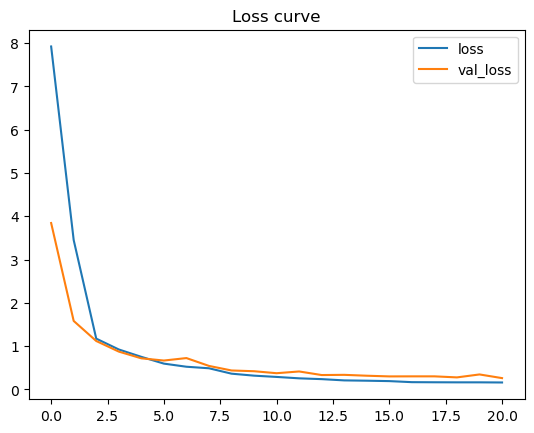

In [17]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve');

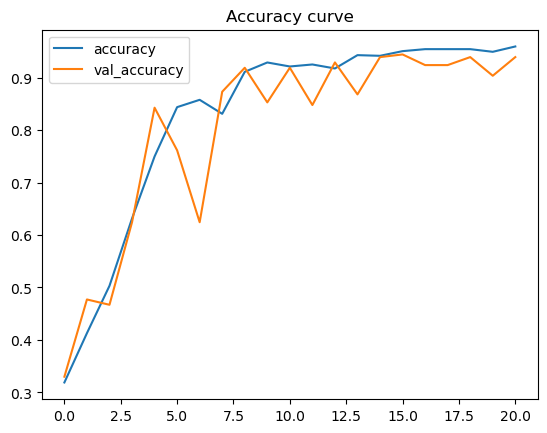

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve');

In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy

7/7 [==============================] - 0s 14ms/step - loss: 0.3002 - accuracy: 0.9442


(0.3001583218574524, 0.9441624283790588)

In [20]:
y_pred = np.argmax(model.predict(X_test), axis=1)

7/7 [==============================] - 0s 13ms/step


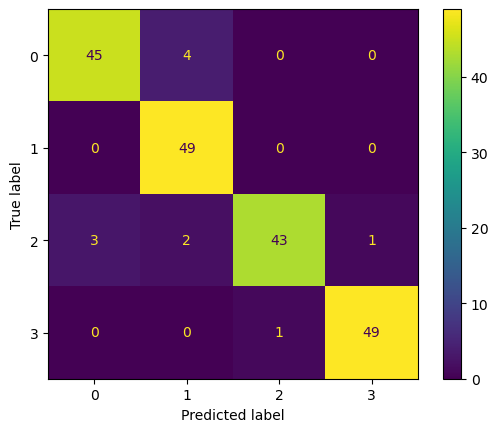

In [21]:
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), y_pred);

### Построение нейронной сети в 13 слоев

In [93]:
model=Sequential()
model.add(Conv2D(32, (3,3), input_shape=(120,120,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dense(4,activation="softmax"))

In [94]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [95]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [96]:
history = model.fit(X_train,
                    y_train,
                    batch_size=8,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/30
99/99 [==============================] - 3s 30ms/step - loss: 1.1920 - accuracy: 0.4409 - val_loss: 1.1385 - val_accuracy: 0.4822
Epoch 2/30
99/99 [==============================] - 3s 29ms/step - loss: 0.9972 - accuracy: 0.5197 - val_loss: 0.9929 - val_accuracy: 0.5685
Epoch 3/30
99/99 [==============================] - 3s 28ms/step - loss: 0.9221 - accuracy: 0.5616 - val_loss: 0.9300 - val_accuracy: 0.5482
Epoch 4/30
99/99 [==============================] - 3s 28ms/step - loss: 0.8293 - accuracy: 0.6175 - val_loss: 0.8484 - val_accuracy: 0.5685
Epoch 5/30
99/99 [==============================] - 3s 28ms/step - loss: 0.7762 - accuracy: 0.6429 - val_loss: 0.8249 - val_accuracy: 0.6345
Epoch 6/30
99/99 [==============================] - 3s 28ms/step - loss: 0.6800 - accuracy: 0.7052 - val_loss: 0.7639 - val_accuracy: 0.7157
Epoch 7/30
99/99 [==============================] - 3s 28ms/step - loss: 0.6348 - accuracy: 0.7332 - val_loss: 0.6380 - val_accuracy: 0.7665
Epoch 8/30
99

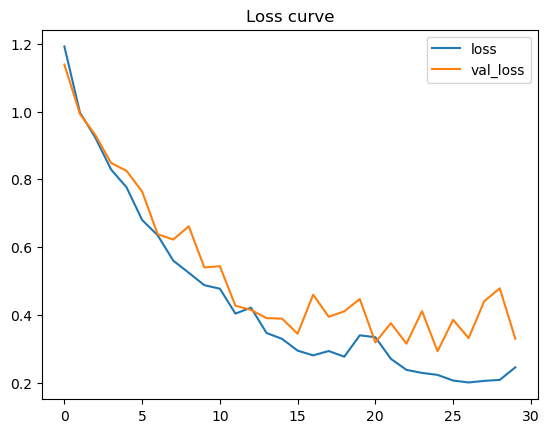

In [97]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve');

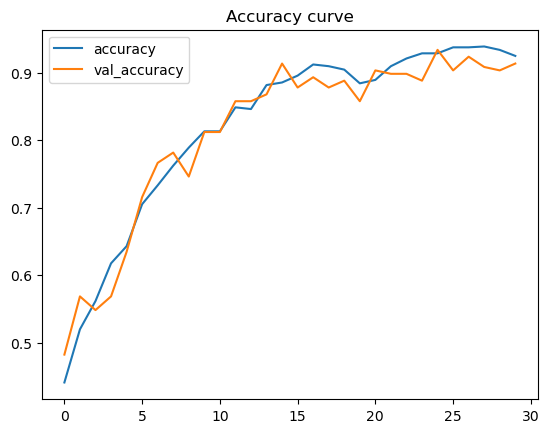

In [98]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve');

In [99]:
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy

7/7 [==============================] - 0s 20ms/step - loss: 0.2926 - accuracy: 0.9340


(0.29259592294692993, 0.9340101480484009)

In [100]:
y_pred = np.argmax(model.predict(X_test), axis=1)

7/7 [==============================] - 0s 19ms/step


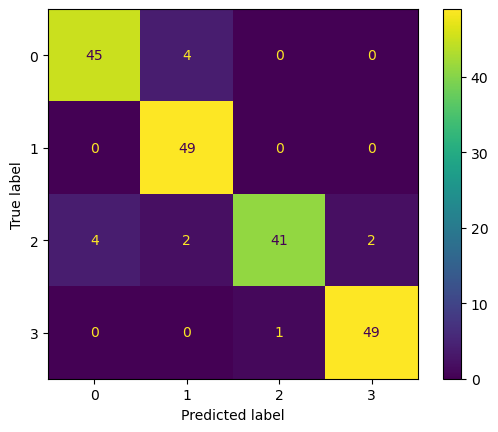

In [101]:
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), y_pred);

В нейронной сети из 13 слоев было убрано 2 слоя Dropout, изменено количество фильтров и нейронов в некоторых скрытых слоях.  
Хороший прирост accuracy дало уменьшение batch_size и увеличение эпох обучения.  
Лучший результат: accuracy = 0.9340

**Вывод**

**Лучший результат показала трехслойная нейронная сеть: accuracy = 0.9441**